In [1]:
_git_branch = 'trainset'
%tensorflow_version 1.x

import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


# Import code from gitHub

In [2]:
import json
import subprocess
import sys
import time

import numpy as np
from IPython.core.display import display, HTML
from google.colab import files

!pip install overrides
!pip install pyjarowinkler
 
def exec(x):
  r = subprocess.check_output(x, shell=True)
  r = r.decode('unicode-escape').encode('latin1').decode('utf8')
  print(r)


print(f"fetching code from GitHub.....{_git_branch}")
try:
  exec('rm -r nlp_tools')
except:
  pass
exec(f'git clone --single-branch --branch {_git_branch} https://github.com/nemoware/analyser.git nlp_tools')

print('🦊 GIT revision:')
exec('cd nlp_tools\ngit rev-list --reverse HEAD | awk "{ print NR }" | tail -n 1\ngit branch\ngit log -3 --pretty=%B')

sys.path.insert(0, 'nlp_tools')

print('❤️importing Code from GitHub ... DONE')

#----- other deps

import nltk
nltk.download('punkt')

  Created wheel for overrides: filename=overrides-2.8.0-cp36-none-any.whl size=5609 sha256=b69f8b45594b66cfaff0fde999485a1fb8aa2f8918ba9852e27cd9227ed5dc26
  Stored in directory: /root/.cache/pip/wheels/df/f1/ba/eaf6cd7d284d2f257dc71436ce72d25fd3be5a5813a37794ab
Successfully built overrides
fetching code from GitHub.....trainset

🦊 GIT revision:
1294
* trainset
clean
trying smaller lstm
Created using Colaboratory

❤️importing Code from GitHub ... DONE
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def plot_emb(matrix):
    
  mt = matrix.T
  
  with sns.axes_style("white"):
    plt.figure(figsize=(25, 6))
    ax = sns.heatmap(mt, square=False,  cmap="RdYlBu")
    plt.show()

#Prepare trainset


#### Mount drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Read meta

In [5]:
import pandas as pd
from os import path


TRAINSETS_PATH='/content/drive/My Drive/GazpromOil/trainsets'
VERSION_PATH='1_1_19'
TRAINSET_META_FN='contracts.subjects-manually-filtered.csv'

csv_path = path.join(TRAINSETS_PATH, VERSION_PATH, TRAINSET_META_FN)

trainset_meta = pd.read_csv(csv_path, encoding='utf-8' )
trainset_rows = trainset_meta[trainset_meta['valid']]
print(trainset_rows.info())
# trainset_rows.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 280 to 789
Data columns (total 11 columns):
idx            510 non-null int64
section        510 non-null object
subject        510 non-null object
confidence     510 non-null float64
valid          510 non-null bool
header         510 non-null object
_id            510 non-null object
len            510 non-null int64
pickle         510 non-null object
org-1-alias    404 non-null object
org-2-alias    341 non-null object
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 44.3+ KB
None


###  One-1-hots: subject codes -> `subject_name_1hot_map`

Nemoware Analyser v1.6.8
(33, 43)
dict_keys(['Other', 'Deal', 'Charity', 'RealEstate', 'Loans', 'BigDeal', 'Lawsuit', 'Insurance', 'Consulting', 'RentingOut', 'Renting', 'AgencyContract', 'BankGuarantees', 'RelatedTransactions', 'GeneralContract', 'EmployeeContracts', 'PledgeEncumbrance', 'Liquidation', 'Service', 'CashPayments', 'RefusalToLeaseLand', 'DealGeneralBusiness', 'RevisionCommission', 'Reorganization', 'InterestedPartyTransaction', 'RelatedPartyTransaction', 'AssetTransactions', 'DealIntellectualProperty', 'RealEstateTransactions', 'SecuritiesTransactions', 'RegisteredCapital', 'ParticipationInOtherOrganizations', 'DecisionsForSubsidiary'])


Using TensorFlow backend.


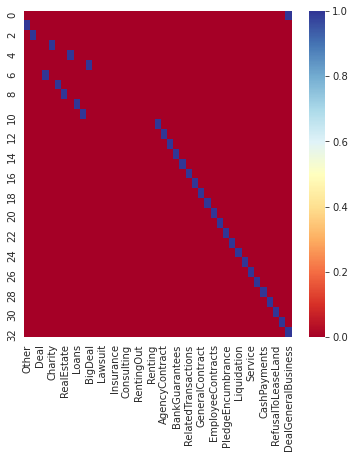

In [6]:

from analyser.structures import ContractSubject
from keras.utils import to_categorical


all_subjects_map ={s.name : s.value  for s in ContractSubject}

# encoding integer subject codes in one-hot vectors
_cats = to_categorical( list(all_subjects_map.values()) )
print(_cats.shape)
print(all_subjects_map.keys())

subject_name_1hot_map={}
for i, k in enumerate(all_subjects_map.keys()):  
  subject_name_1hot_map[k] = _cats[i]

# debug: render all onne-hots as a marix
# plot_emb( np.array( list(  subject_name_1hot_map.values())))

mt = np.array(list( subject_name_1hot_map.values()))
with sns.axes_style("white"):
  plt.figure(figsize=(6, 6))
  ax = sns.heatmap(mt, square=False,  cmap="RdYlBu")
  ax.set_xticklabels(all_subjects_map.keys())
  plt.show()
 

### Balance trainset
TODO: consider https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

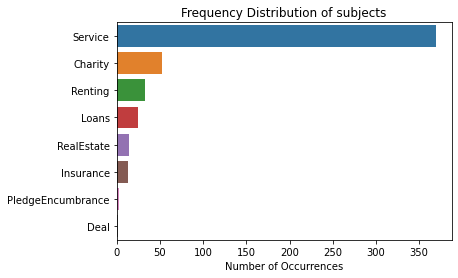


min 1
max 369
total 510


In [7]:


subj_count = trainset_rows['subject'].value_counts()

#plot distribution
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

#### Group by subjects (put row indices into bags)

1. distribute row numbers by bags
2. oversample each bag

In [8]:
#make empty bags
subject_bags = {}
for key in subj_count.index:
  subject_bags[key]=[]
print(subject_bags)


row_no:int = 0
for index, row in trainset_rows.iterrows():

  row_by_no = trainset_rows.iloc[row_no]
  subj_code = row["subject"]
  bag = subject_bags[subj_code]
  bag.append(row_no)
  
  row_no += 1


# --- debug
print('sample bag ')
subject_bags['PledgeEncumbrance']

{'Service': [], 'Charity': [], 'Renting': [], 'Loans': [], 'RealEstate': [], 'Insurance': [], 'PledgeEncumbrance': [], 'Deal': []}
sample bag 


[91, 92, 93]

2. oversample with np.tile: just repeat the indices stored in named bags. 



In [9]:
_desired_number_of_samples = max (subj_count.values)
for subj_code in subject_bags:
  bag = subject_bags[subj_code]
  if len(bag)<_desired_number_of_samples:  
    repeats = int(_desired_number_of_samples / len(bag))
    bag = sorted(np.tile(bag, repeats))
    subject_bags[subj_code] = bag
  print (subj_code, len(bag))

print()
print('sample bag after oversampling:', subject_bags['PledgeEncumbrance'])


Service 369
Charity 364
Renting 363
Loans 350
RealEstate 364
Insurance 364
PledgeEncumbrance 369
Deal 369

sample bag after oversampling: [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 9

split all bags into train and validation sets

In [10]:
VALIDATION_SET_PROPORTION = 0.25
subject_bags_test = {}
subject_bags_train = {}

for subj_code in subject_bags:
  bag = subject_bags[subj_code]
  split_index:int = int(len(bag) * VALIDATION_SET_PROPORTION)
  #print(split_index)
  
  subject_bags_test [subj_code] = bag[:split_index]
  subject_bags_train [subj_code] = bag[split_index:]

print('\n--subject_bags_train')
for subj_code in subject_bags_train:
  bag = subject_bags_train[subj_code]  
  print (subj_code, len(bag))
print('\n--subject_bags_test')
for subj_code in subject_bags_test:
  bag = subject_bags_test[subj_code]  
  print (subj_code, len(bag))


--subject_bags_train
Service 277
Charity 273
Renting 273
Loans 263
RealEstate 273
Insurance 273
PledgeEncumbrance 277
Deal 277

--subject_bags_test
Service 92
Charity 91
Renting 90
Loans 87
RealEstate 91
Insurance 91
PledgeEncumbrance 92
Deal 92


## Batch generator

TODO: try different embedding padding

In [11]:
import pickle

import numpy as np
from keras.preprocessing.sequence import pad_sequences

from analyser.legal_docs import LegalDocument

train_indices = []
test_indices = []

for _arr in subject_bags_train.values():
  train_indices += _arr;

for _arr in subject_bags_test.values():
  test_indices += _arr;

print('test_indices=', len(test_indices))
print('train_indices=', len(train_indices))

# TODO: they probably intersect!!


MAX_SEQUENCE_LENGTH = 999

embeddings_cache = {}


def get_embeddings(filename):
  if filename in embeddings_cache:
    return embeddings_cache[filename]
  else:
    with open(filename, "rb") as pickle_in:
      # print('reading... ', filename)
      doc: LegalDocument = pickle.load(pickle_in)
      embedding = pad_sequences([doc.embeddings], maxlen=MAX_SEQUENCE_LENGTH)[0]
      # print(doc.embeddings.shape, 'vs', embedding.shape)

    embeddings_cache[filename] = embedding
    return embedding


def subj_batch_generator(batch_size, all_indices):
  while True:
    # Select files (paths/indices) for the batch
    batch_indices = np.random.choice(a=all_indices, size=batch_size)

    batch_input = []
    batch_output = []

    # Read in each input, perform preprocessing and get labels
    for i in batch_indices:
      _row = trainset_rows.iloc[i]
      _subj = _row['subject']
      _filename = _row['pickle']
      _emb = get_embeddings(_filename)

      _subject_emb = subject_name_1hot_map[_subj]

      batch_input += [_emb]
      batch_output += [_subject_emb]

    # Return a tuple of (input, output) to feed the network    
    batch_x = np.array(batch_input)
    batch_y = np.array(batch_output)

    yield (batch_x, batch_y)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
loading word cases stats model /content/nlp_tools/analyser/vocab/word_cases_stats.pickle
test_indices= 726
train_indices= 2186


In [0]:
EPOCHS=8
BATCH_SIZE=48
EMB=1024 #;//X.shape[-1]

CLASSES=len(list(subject_name_1hot_map.values())[0])


#create gens
test_generator = subj_batch_generator(BATCH_SIZE, all_indices = test_indices)
train_generator = subj_batch_generator(BATCH_SIZE, all_indices = train_indices)
all_generator = subj_batch_generator(BATCH_SIZE, all_indices = train_indices+test_indices)


#debug ---------------------
_t_x, _t_y =  next(test_generator)
print("sample", _t_x.shape)
print("sample", _t_y.shape)

plot_emb(_t_x[3])

# Build Models

### common

In [13]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from IPython.display import SVG


from tensorflow import keras
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout
from keras.models import Sequential, Model
 
  


1.15.2


In [0]:
HISTORIES={}

def plot_training_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  

def plot_compare_models():
  for key in HISTORIES:
    history=HISTORIES[key]
#     plt.plot(history.history['loss'], label=f'{key} loss')
    plt.plot(history.history['val_loss'], label=f'{key} val_loss')
  
  plt.title('Models loss')   
  plt.legend(loc='upper left')
  plt.show()

In [15]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from os import mkdir

model_checkpoint_path = csv_path = path.join(TRAINSETS_PATH, 'checkpoints', VERSION_PATH)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1E-6, verbose=1)

print('model_checkpoint_path', model_checkpoint_path)
 


model_checkpoint_path /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19


In [16]:

validation_steps = int(len(test_indices)/BATCH_SIZE)
steps_per_epoch = int(len(train_indices)/BATCH_SIZE/2)

print('validation_steps=', validation_steps)
print('steps_per_epoch=', steps_per_epoch)

def train_and_evaluate_model(model, generator=train_generator):
  checkpoint = ModelCheckpoint( path.join(model_checkpoint_path, model.name), 
                               monitor='val_loss', mode='min', save_best_only=True,
                               verbose=1) 
  history = model.fit_generator(
      generator=generator, 
      epochs=EPOCHS,  callbacks=[reduce_lr, checkpoint], steps_per_epoch=steps_per_epoch,
      validation_data = test_generator,
      validation_steps=validation_steps )

  HISTORIES[model.name]=history
  plot_training_history(history)
  plot_compare_models()



validation_steps= 15
steps_per_epoch= 22


## models

### baseline LSTM model

In [17]:

# define baseline model
def baseline_LSTM_model():
  classes = min(10, CLASSES)

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
	 
  bi =  LSTM(classes*4, return_sequences=False)(input_text)  
  dense = Dense(CLASSES, activation='softmax')(bi)
  _out = dense
  model = Model(inputs=[input_text], outputs=_out, name='baseline_LSTM_model')
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  model.summary()
  return model



 
model = baseline_LSTM_model(  )
# SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
 

# print("TEST:--does it work?")
# k=model.predict( X)
# k[0]







Model: "baseline_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 40)                170400    
_________________________________________________________________
dense_1 (Dense)              (None, 43)                1763      
Total params: 172,163
Trainable params: 172,163
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/32





22/22 [==============================] - 120s 5s/step - loss: 2.8538 - acc: 0.4413 - val_loss: 2.1084 - val_acc: 0.5792

Epoch 00001: val_loss improved from inf to 2.10842, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/baseline_LSTM_model
Epoch 2/32
22/22 [==============================] - 47s 2s/step - loss: 1.1223 - acc: 0.8731 - val_loss: 0.8141 - val_acc: 0.9778

Epoch 00002: val_loss improved from 2.10842 to 0.81407, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/baseline_LSTM_model
Epoch 3/32
22/22 [==============================] - 37s 2s/step - loss: 0.3444 - acc: 0.9792 - val_loss: 0.5040 - val_acc: 0.8806

Epoch 00003: val_loss improved from 0.81407 to 0.50397, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/baseline_LSTM_model
Epoch 4/32
22/22 [======================

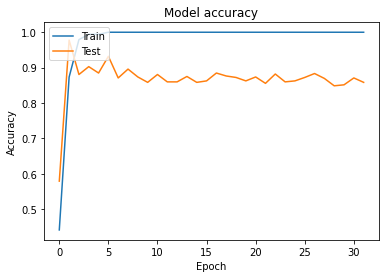

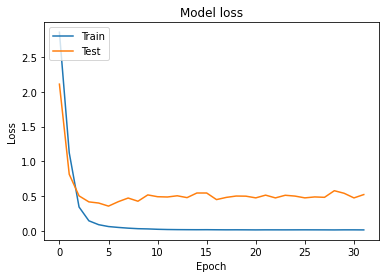

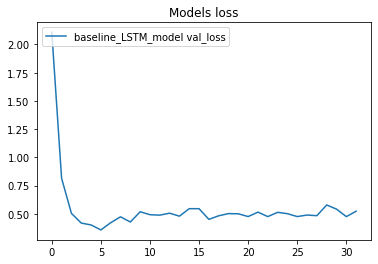

In [18]:
EPOCHS=32
train_and_evaluate_model(model)

In [19]:
e=model.evaluate_generator(generator=test_generator, steps=100)
print(e)

[0.5080123087763786, 0.8647916692495347]


### baseline bi-GRU  model
overfits

In [23]:
def simple_bi_GRU_model(name="new_model"):
  classes = min(10, CLASSES)

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
	 
  bi =  Bidirectional(GRU(classes*2, return_sequences=False))(input_text)   
  dense = Dense(CLASSES, activation='softmax')(bi)
  _out = dense
  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  model.summary()
  
  return model


 
model = simple_bi_GRU_model( simple_bi_GRU_model.__name__ )
# SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

# print("TEST:--does it work?")
# k=model.predict( X)
# k[0]


Model: "simple_bi_GRU_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40)                125400    
_________________________________________________________________
dense_3 (Dense)              (None, 43)                1763      
Total params: 127,163
Trainable params: 127,163
Non-trainable params: 0
_________________________________________________________________


In [0]:
# SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

Epoch 1/32
22/22 [==============================] - 54s 2s/step - loss: 3.0270 - acc: 0.4394 - val_loss: 2.5371 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 2.53707, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/simple_bi_GRU_model
Epoch 2/32
22/22 [==============================] - 50s 2s/step - loss: 1.8536 - acc: 0.7225 - val_loss: 1.8002 - val_acc: 0.6139

Epoch 00002: val_loss improved from 2.53707 to 1.80021, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/simple_bi_GRU_model
Epoch 3/32
22/22 [==============================] - 51s 2s/step - loss: 1.1718 - acc: 0.8807 - val_loss: 1.4311 - val_acc: 0.6458

Epoch 00003: val_loss improved from 1.80021 to 1.43113, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/simple_bi_GRU_model
Epoch 4/32
22/22 [==============================] - 51s 2s/step - loss: 0.8045 - acc: 0.9479 - val_loss: 1.2095 - val_acc: 0.6708

Epoch 00004:

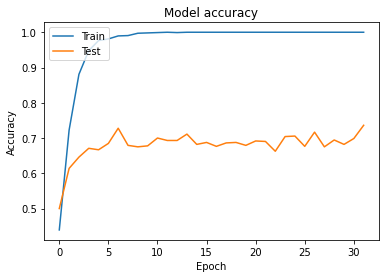

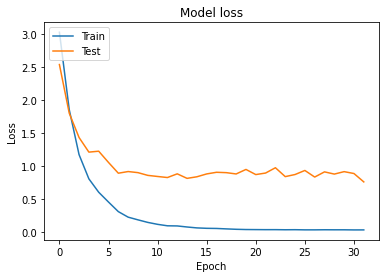

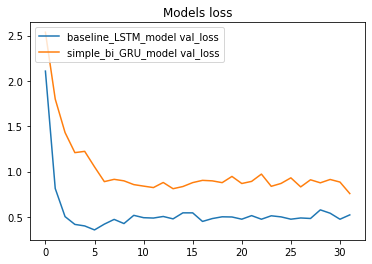

In [25]:

EPOCHS=32
train_and_evaluate_model(model)

In [26]:
model.evaluate_generator(generator=test_generator, steps=100)

[0.918385394513607, 0.6789583343267441]

In [27]:
model.evaluate_generator(generator=train_generator, steps=100)

[0.030149191971868276, 1.0]

### simple LSTM model + Dropouts

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "simple_LSTM_model_drops"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                170400    
_________________________________________________________________
dense_4 (Dense)              (None, 43)                1763      
Total params: 172,163
Trainable params: 172,163
Non-trainable params: 0
_________________________________________________________________


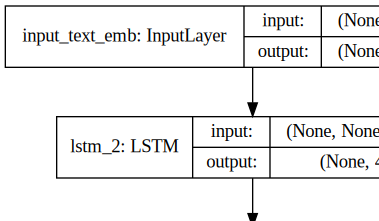

In [28]:

# define baseline model
def simple_LSTM_model_drops(name="no_name"):
  classes = min(10, CLASSES)

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
	 
  bi =  LSTM(classes*4, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)(input_text)  
  dense = Dense(CLASSES, activation='softmax')(bi)
  _out = dense
  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
  
  model.summary()
  return model


 
model = simple_LSTM_model_drops( simple_LSTM_model_drops.__name__ )
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
 

# print("TEST:--does it work?")
# k=model.predict( X)
# k[0]


Epoch 1/32
22/22 [==============================] - 38s 2s/step - loss: 2.5037 - acc: 0.4015 - val_loss: 1.2709 - val_acc: 0.6861

Epoch 00001: val_loss improved from inf to 1.27086, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/simple_LSTM_model_drops
Epoch 2/32
22/22 [==============================] - 37s 2s/step - loss: 0.7903 - acc: 0.8684 - val_loss: 0.6866 - val_acc: 0.7361

Epoch 00002: val_loss improved from 1.27086 to 0.68662, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/simple_LSTM_model_drops
Epoch 3/32
22/22 [==============================] - 36s 2s/step - loss: 0.2873 - acc: 0.9631 - val_loss: 0.5329 - val_acc: 0.8514

Epoch 00003: val_loss improved from 0.68662 to 0.53286, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/simple_LSTM_model_drops
Epoch 4/32
22/22 [==============================] - 36s 2s/step - loss: 0.1342 - acc: 0.9886 - val_loss: 0.3980 - val_acc: 0.8458



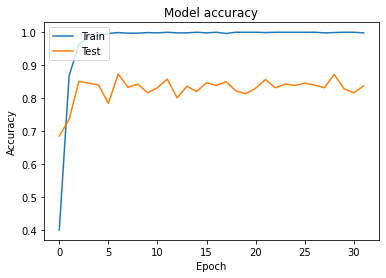

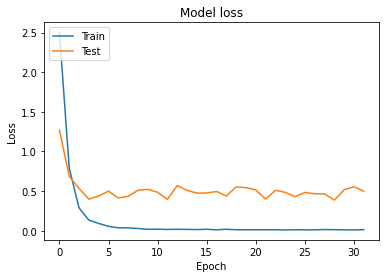

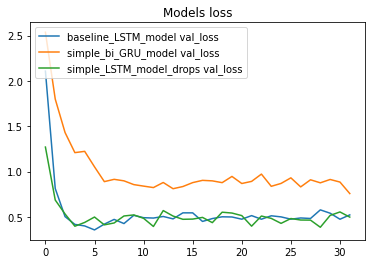

In [29]:
# EPOCHS=16
train_and_evaluate_model(model)

In [30]:
e=model.evaluate_generator(generator=test_generator, steps=100)
print(e)

[0.4770390363037586, 0.8358333331346511]


In [31]:
e=model.evaluate_generator(generator=all_generator, steps=100)
print(e)

[0.11907755377236753, 0.960208335518837]


### smaller LSTM model + Dropouts

In [32]:

# define baseline model
def smaller_LSTM_model_drops(name="no_name"):
  classes = min(10, CLASSES)

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
	 
  bi =  LSTM(classes, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)(input_text)  
  dense = Dense(CLASSES, activation='softmax')(bi)
  _out = dense
  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
  
  model.summary()
  return model


 
model = smaller_LSTM_model_drops( smaller_LSTM_model_drops.__name__ )
# SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
 

Model: "smaller_LSTM_model_drops"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                41400     
_________________________________________________________________
dense_5 (Dense)              (None, 43)                473       
Total params: 41,873
Trainable params: 41,873
Non-trainable params: 0
_________________________________________________________________


Epoch 1/32
22/22 [==============================] - 39s 2s/step - loss: 3.3298 - acc: 0.2017 - val_loss: 2.7582 - val_acc: 0.3611

Epoch 00001: val_loss improved from inf to 2.75819, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/smaller_LSTM_model_drops
Epoch 2/32
22/22 [==============================] - 36s 2s/step - loss: 2.3027 - acc: 0.5227 - val_loss: 1.9532 - val_acc: 0.5625

Epoch 00002: val_loss improved from 2.75819 to 1.95322, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/smaller_LSTM_model_drops
Epoch 3/32
22/22 [==============================] - 36s 2s/step - loss: 1.6251 - acc: 0.7633 - val_loss: 1.5808 - val_acc: 0.7528

Epoch 00003: val_loss improved from 1.95322 to 1.58079, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/smaller_LSTM_model_drops
Epoch 4/32
22/22 [==============================] - 36s 2s/step - loss: 1.2410 - acc: 0.9034 - val_loss: 1.3349 - val_acc: 0.758

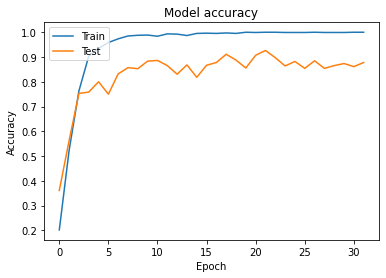

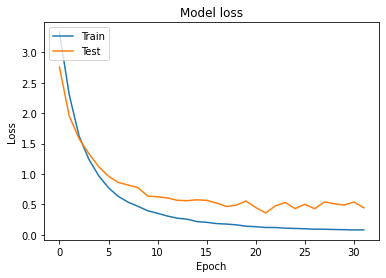

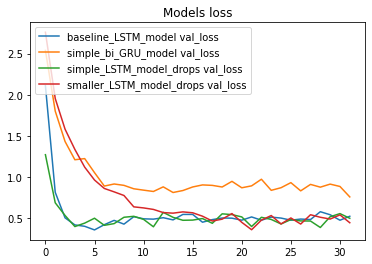

In [33]:
EPOCHS=32
train_and_evaluate_model(model)

In [34]:
e=model.evaluate_generator(generator=test_generator, steps=100)
print(e)

[0.45429866075515746, 0.8764583307504654]


In [35]:
e=model.evaluate_generator(generator=all_generator, steps=100)
print(e)

[0.16832914434373378, 0.9672916692495346]


### small LSTM model + Dropout layer

In [36]:

# define baseline model
def small_LSTM_model_dropout_l(name="no_name"):
  classes = min(16, CLASSES)

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
	
  dr = Dropout(0.1, name="drops")(input_text)
  # bi =  LSTM(classes, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)(dr)  
  bi =  LSTM(classes, return_sequences=False, dropout=0.05, recurrent_dropout=0.05)(dr)  
  dense = Dense(CLASSES, activation='softmax')(bi)
  _out = dense
  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
  
  model.summary()
  return model


 
model = small_LSTM_model_dropout_l( small_LSTM_model_dropout_l.__name__ )
# SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
 

Model: "small_LSTM_model_dropout_l"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
drops (Dropout)              (None, None, 1024)        0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                66624     
_________________________________________________________________
dense_6 (Dense)              (None, 43)                731       
Total params: 67,355
Trainable params: 67,355
Non-trainable params: 0
_________________________________________________________________


Epoch 1/32
22/22 [==============================] - 40s 2s/step - loss: 2.8651 - acc: 0.5748 - val_loss: 1.9987 - val_acc: 0.6542

Epoch 00001: val_loss improved from inf to 1.99869, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/small_LSTM_model_dropout_l
Epoch 2/32
22/22 [==============================] - 37s 2s/step - loss: 1.2992 - acc: 0.9252 - val_loss: 1.1306 - val_acc: 0.7694

Epoch 00002: val_loss improved from 1.99869 to 1.13058, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/small_LSTM_model_dropout_l
Epoch 3/32
22/22 [==============================] - 37s 2s/step - loss: 0.6601 - acc: 0.9830 - val_loss: 0.7981 - val_acc: 0.8986

Epoch 00003: val_loss improved from 1.13058 to 0.79813, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/small_LSTM_model_dropout_l
Epoch 4/32
22/22 [==============================] - 37s 2s/step - loss: 0.4145 - acc: 0.9924 - val_loss: 0.6790 - val_acc:

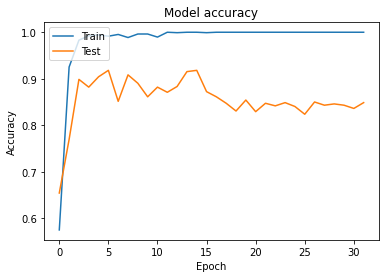

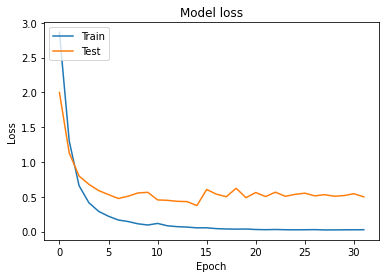

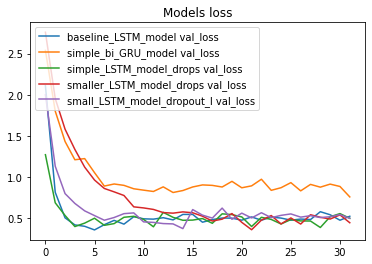

In [37]:
EPOCHS=32
train_and_evaluate_model(model)

In [38]:
e=model.evaluate_generator(generator=test_generator, steps=100)
print(e)

[0.545985923781991, 0.8358333331346511]


In [39]:
e=model.evaluate_generator(generator=all_generator, steps=100)
print(e)

[0.14382789321243764, 0.9625]


#Train final model

Model: "baseline_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 40)                170400    
_________________________________________________________________
dense_7 (Dense)              (None, 43)                1763      
Total params: 172,163
Trainable params: 172,163
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
22/22 [==============================] - 35s 2s/step - loss: 2.7412 - acc: 0.4422 - val_loss: 1.6429 - val_acc: 0.8222

Epoch 00001: val_loss improved from inf to 1.64285, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/baseline_LSTM_model
Epoch 2/32
22/22 [==============================] - 31s 1s/step - loss: 0.9059 - acc: 0.

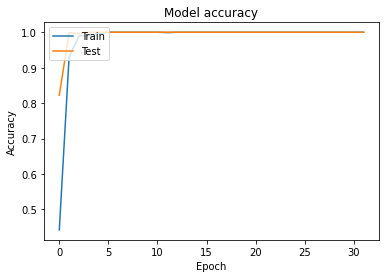

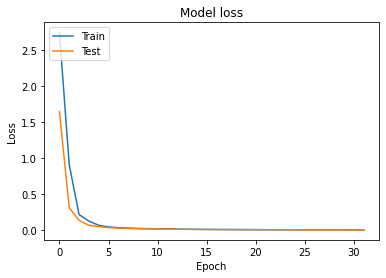

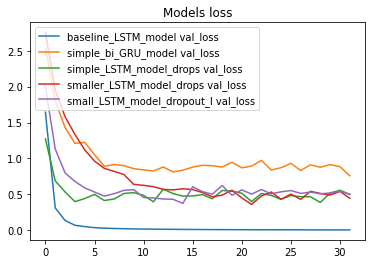

In [40]:
# generator
final_model = baseline_LSTM_model(  )
train_and_evaluate_model(final_model, generator=all_generator)

# Playground

In [0]:
model=final_model


row_no:int=0

prediction_col_name='predicted_subj'
model_validation_meta = trainset_meta[ trainset_meta['subject']!='?' ].copy()
model_validation_meta[prediction_col_name]='?'
model_validation_meta[prediction_col_name+"_conf"]=0.0
model_validation_meta[prediction_col_name+"_valid"]=False

for index, row in model_validation_meta.iterrows():
  row_by_no = model_validation_meta.iloc[row_no]

  _subj=row_by_no['subject']
  _filename=row_by_no['pickle']   
  
  _emb = get_embeddings(_filename)  
  _onehot = subject_name_1hot_map[ _subj ]

  

  result = model.predict( np.array( []+ [_emb]) )
  max_i=result[0].argmax()
  predicted_subj_name=ContractSubject(max_i).name

  model_validation_meta[prediction_col_name][index]  = predicted_subj_name
  model_validation_meta[prediction_col_name+"_conf"][index]  = result[0][max_i]
  model_validation_meta[prediction_col_name+"_valid"][index]  = predicted_subj_name==_subj

  print(row_no, index, _subj,'-->', predicted_subj_name, row_by_no['valid'], result[0][max_i] )
  

  if row_no%5==0:
    model_validation_meta.to_csv(path.join(model_checkpoint_path, model.name)+'.csv', encoding='utf-8', index=True)
    model_validation_meta.to_csv(  model.name+'.csv', encoding='utf-8', index=True)

  row_no+=1

  # if row_no > 21:
  #   break

model_validation_meta.to_csv(  model.name+'.csv', encoding='utf-8', index=True)

In [0]:

model_validation_meta[model_validation_meta[prediction_col_name] != '?']